# Summary
- in progress

# Outline
- 1: Sequence of Three Auto Functions that Inform Further Search
- 2: Look for Orbital Period with Periodograms
- 3: Look for Orbital Period with LC
- 4: Look for Super-Orbital Period with Periodograms
- 5: Look for Super-Orbital Period with LC

In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
# from lmfit.models import GaussianModel
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

In [2]:
cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')
orb = float(cross[cross['src_n']==6]['Porb'])
orb

17.2

In [3]:
full[[full['src_n']==6]]

src_n,OGLE,RA_OGLE,DEC_OGLE,ra_deg,dec_deg,perr,period,Porb,_RAJ2000_1,_DEJ2000_1,__M2002_,Vmag_1,Separation_1,_RAJ2000_2,_DEJ2000_2,Vmag_2,recno,Separation
int64,str38,str11,str11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64
6,SMC719.18 \#378,00:57:02.19,-72:25:55.4,14.259583,-72.43188,0.5,5.05,17.2,14.259,-72.43205555555556,38990,15.41,0.9025146211539117,14.259494999999996,-72.43200999999999,15.963,3025245,0.48787528316106876


- orbital period 17.2 days
- spin period 5.05 days

# 1: Sequence of Three Auto Functions that Inform Further Search

orbital period: 17.2


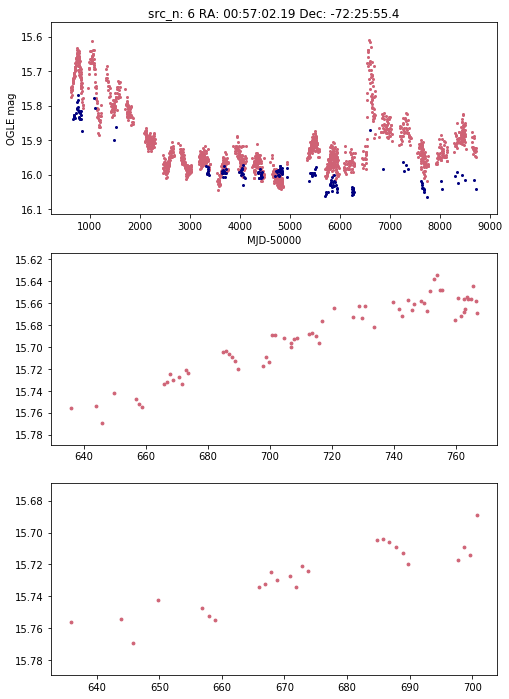

In [4]:
ilist,vlist = o.getIV(6,cross,plot=True,zooms=True,figsize=(8,12),mult=(3,8),offset=10,stack=False) #sometimes good to adjust offset
iband,vband = vstack(ilist),vstack(vlist)

In [5]:
idays = iband['MJD-50000']
imag = iband['I mag']
ierr = iband['I mag err']

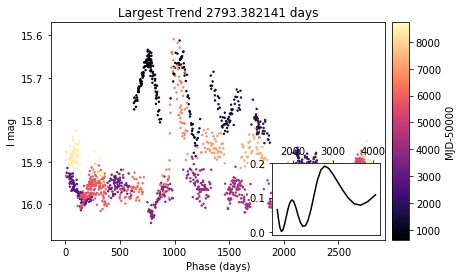

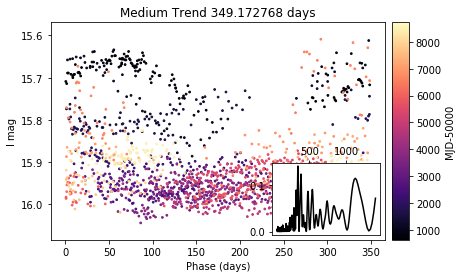

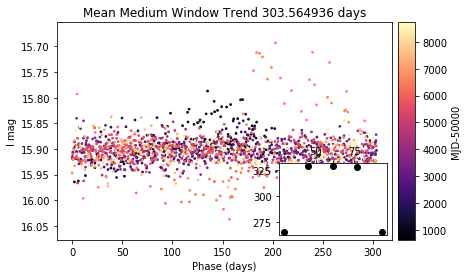

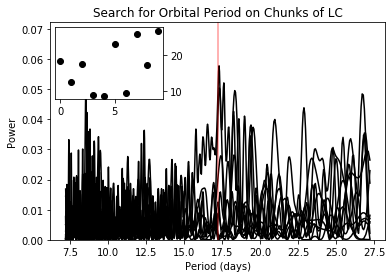

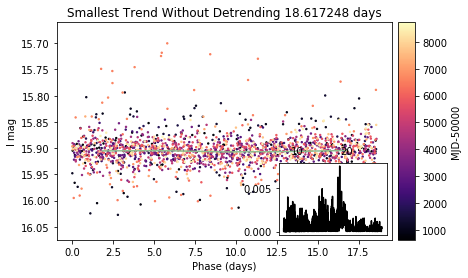

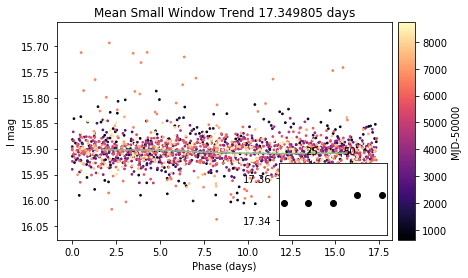

In [8]:
reload(o)
o.autopd(iband,orb,plotpd=True,plotphase=True,printall=False,ctime=True,orb_bounds=(10,10),cutlc=True,numcuts=10,plotdet=True,pbins=5,saveall=False,srcnum=6)

I and V-I correlation: -0.7854401757019701
V and V-I correlation: -0.44726007362846626


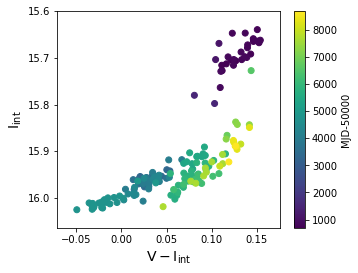

In [10]:
reload(o)
interp = o.colormag(iband,vband,ctime=True,retint=True) 

Text(0.5, 0, 'V-I')

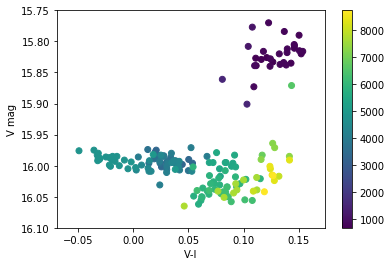

In [13]:
#V vs. V-I
plt.scatter(vband['V mag']-interp,vband['V mag'],c=vband['MJD-50000'])
plt.colorbar()
plt.ylabel('V mag')
plt.ylim(16.1,15.75)
plt.xlabel('V-I')

(16.1, 15.5)

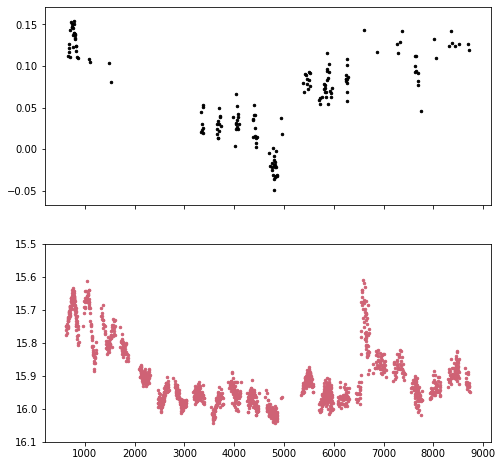

In [21]:
# V-I vs. time
fig,ax = plt.subplots(2,1,figsize=(8,8),sharex=True)
ax[0].scatter(vband['MJD-50000'],vband['V mag']-interp,color='black',s=6)
# plt.colorbar(label=('I mag'))
ax[1].scatter(idays,imag,color=pink,s=6)
ax[1].set_ylim(16.1,15.5)



# 2: Look for Orbital Period with Periodograms

by OGLE epoch then dense regions (but can be broken up by >20 days)

In [22]:
len(ilist)

3

start ind: 0, end ind: -1
start ind: 0, end ind: -1
start ind: 0, end ind: -1


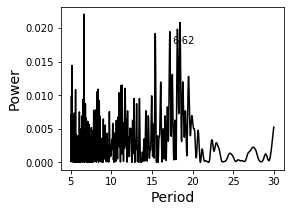

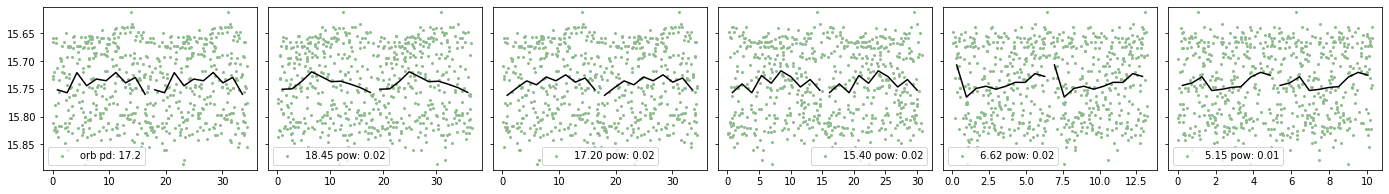

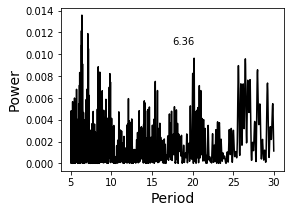

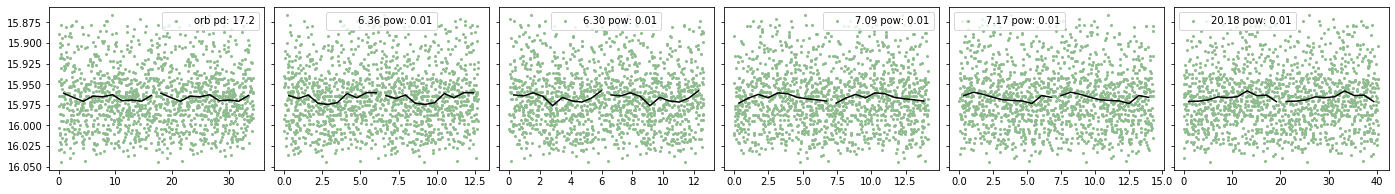

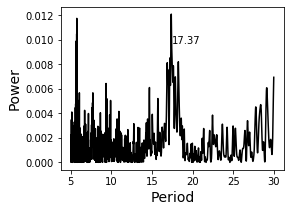

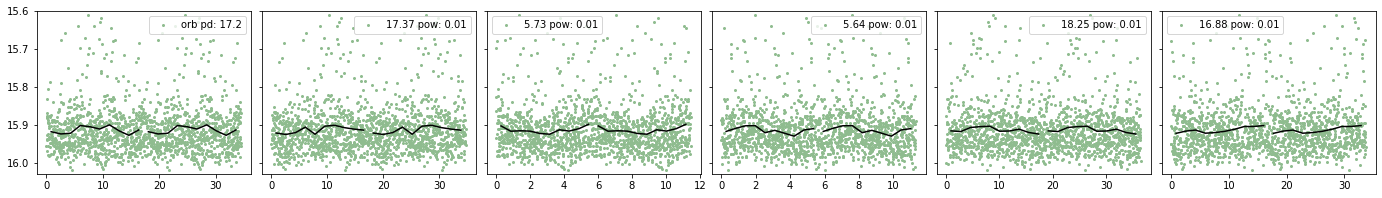

In [24]:
#did wider search but peaks here
reload(o)
pf1 = o.multiphase(ilist[0],orb=orb,dense=False,minp=5,maxp=30,plotpd=True,pkorder=True)
pf2 = o.multiphase(ilist[1],orb=orb,dense=False,minp=5,maxp=30,plotpd=True,pkorder=True)
pf3 = o.multiphase(ilist[2],orb=orb,dense=False,minp=5,maxp=30,plotpd=True,pkorder=True)

<Quantity 17.35578977>

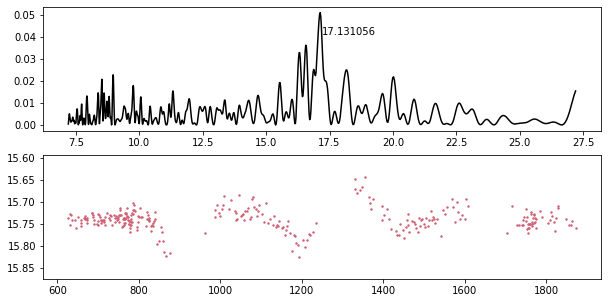

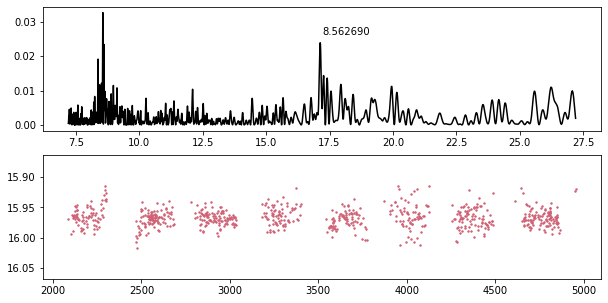

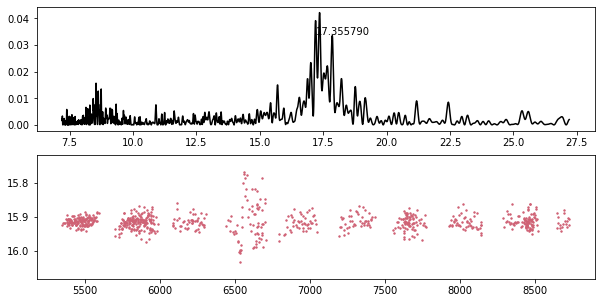

In [26]:
#detrending each OGLE epoch
#varies just a bit based on window
o.knownorb(ilist[0],orb,lower=10,upper=10,window=31,cutdata=False,cut1=0,cut2=500,plotdet=True,figsize=(10,5))
o.knownorb(ilist[1],orb,lower=10,upper=10,window=31,cutdata=False,cut1=0,cut2=500,plotdet=True,figsize=(10,5))
o.knownorb(ilist[2],orb,lower=10,upper=10,window=31,cutdata=False,cut1=0,cut2=500,plotdet=True,figsize=(10,5))

**separate into regions**

start ind: 1172, end ind: 1346


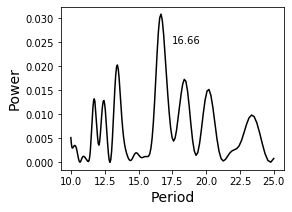

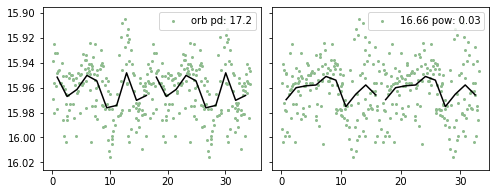

In [27]:
#search and fold with densest region (max space up to 50 points)
df,pks = o.multiphase(iband,orb=orb,dense=True,maxspace=50,minp=10,maxp=25,plotpd=True)

In [28]:
dense,mdense = o.finddense(iband,maxspace=50,retall=True)

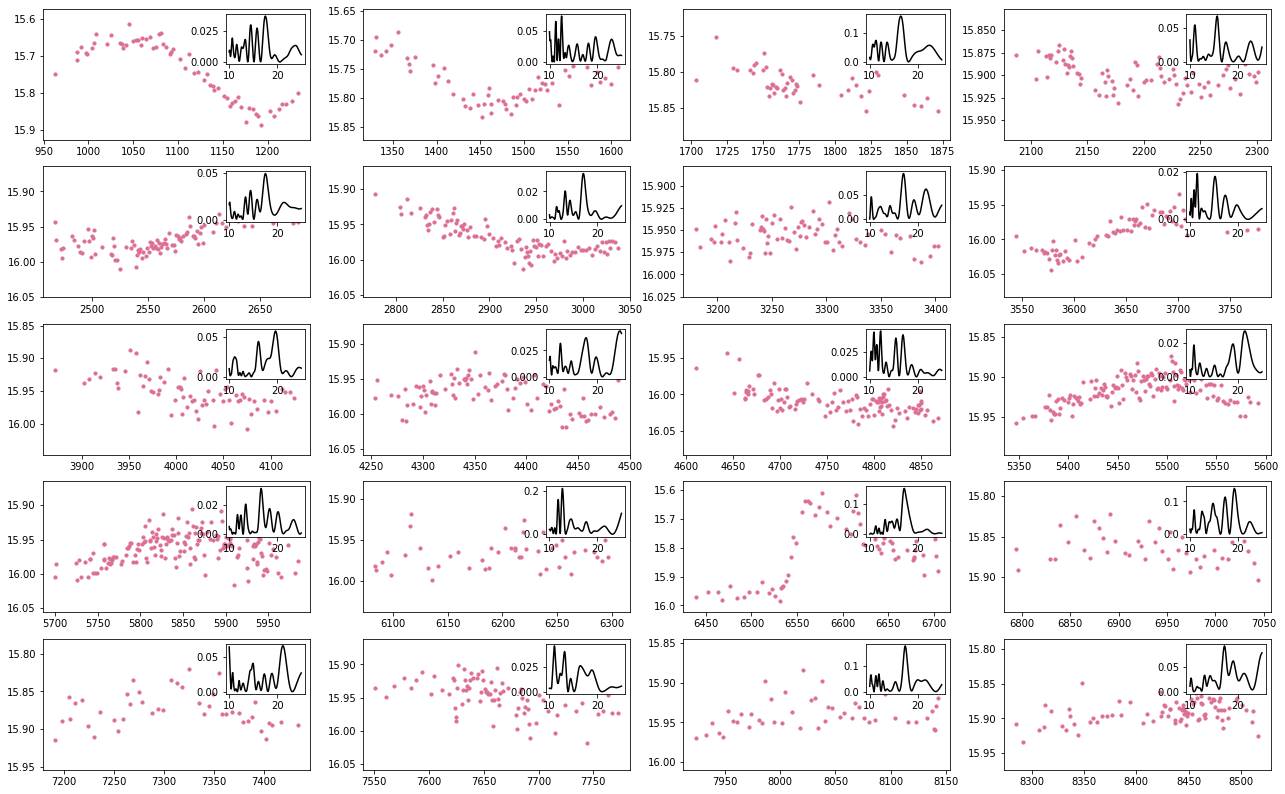

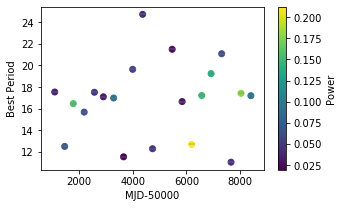

In [29]:
bps,maxpows,stdate,endate = o.denselcpd(iband,dense,minp=10,maxp=25,plotbest=True,onlybp=True)

In [30]:
bps

[17.54465228167481,
 12.505059662867327,
 16.46808263342358,
 15.68403281804076,
 17.520516909421314,
 17.09748292187034,
 16.988698602084366,
 11.540237429223872,
 19.643406685603903,
 24.736537742570228,
 12.289485851292365,
 21.49883468964393,
 16.659635593149513,
 12.690127695401136,
 17.221120358326324,
 19.24173650800475,
 21.088152934652015,
 11.044600619097395,
 17.426638360470207,
 17.201933154139212]

#### by year
- **to do: make year periodogram function**

In [31]:
#make tab for each year in LC
years = []
stdate = iband['MJD-50000'][0]
endate = iband['MJD-50000'][-1]
y = 1
while y < int((endate-stdate)/365)+1:
    #less than next year
    year = iband[iband['MJD-50000']<stdate+365*y]
    #also more than previous
    year = year[year['MJD-50000']>stdate+365*(y-1)]

    years.append(year)
    y+=1

In [34]:
len(years)

22

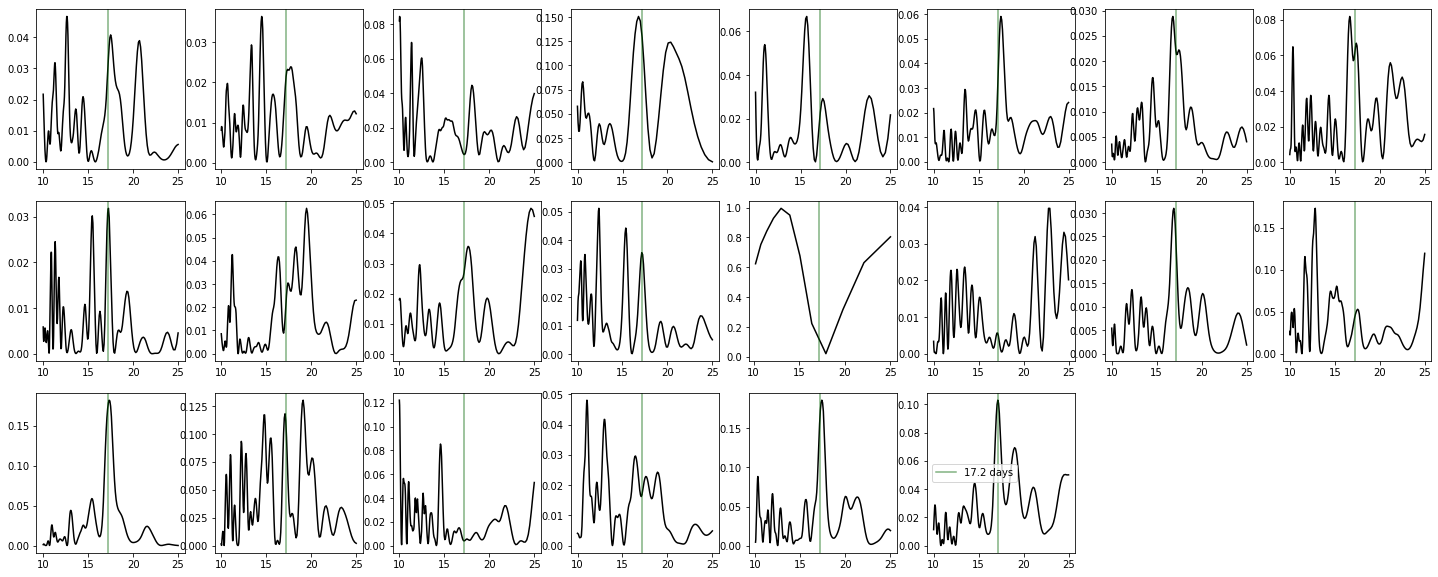

In [43]:
#with multiphase big cell but nice to see what fold of known orb looks like even when it's not a peak
reload(o)
fig = plt.figure(figsize=(25,10))
bps = []
p = 1
for y in years:
    freq,power,bp = o.periodogram(y,minp=10,maxp=25,more=True,plot=False)
    bps.append(float(bp))
    ax = fig.add_subplot(3,8,p)
    ax.plot(1/freq,power,color='black')
    ax.axvline(orb,color='darkgreen',alpha=0.5,label='17.2 days')

    p+=1
ax.legend()

Text(0.5, 0, 'Year')

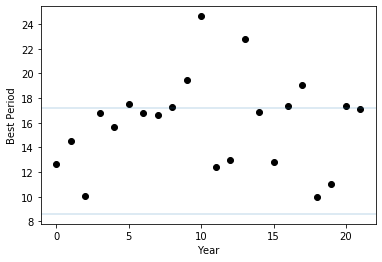

In [39]:
plt.scatter(np.arange(22),bps,color='black')
plt.axhline(orb,alpha=0.2)

plt.ylabel('Best Period')
plt.xlabel('Year')

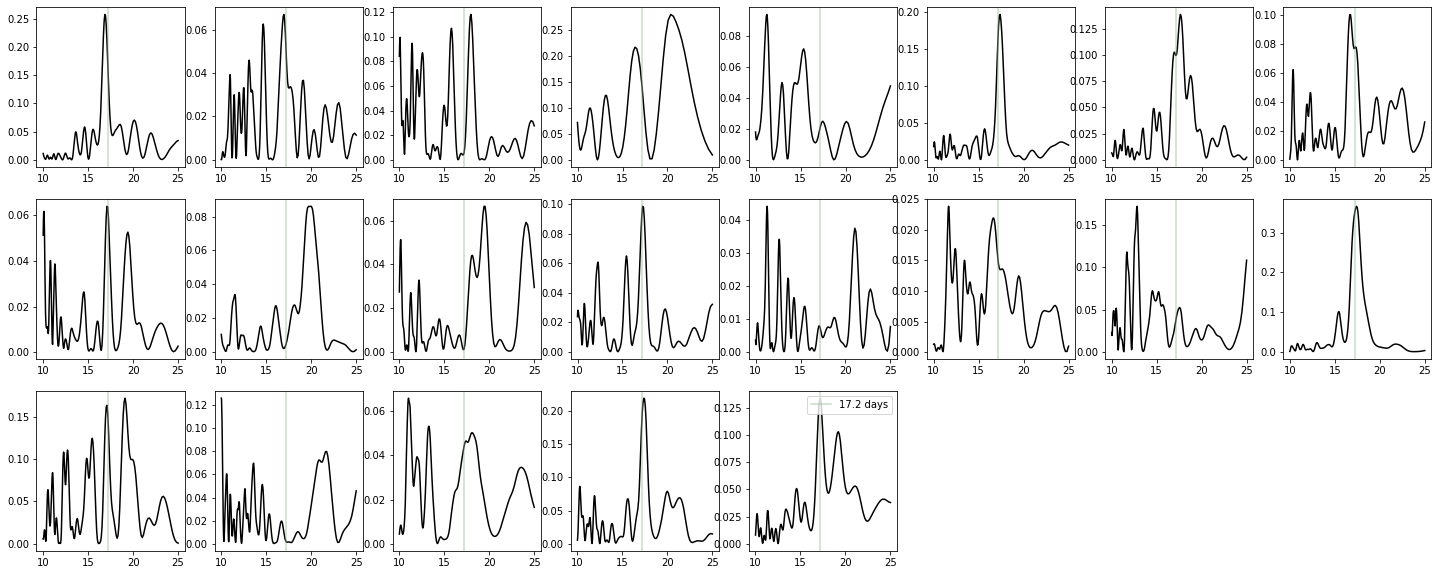

In [45]:
#repeat with detrending -- can adjust window size and then more years will have enough points
reload(o)
fig = plt.figure(figsize=(25,10))
bps = []
p = 1
for y in years:
    if len(y)>31:
        o.detrend(y,window=31)
        freq,power,bp = o.periodogram(y,minp=10,maxp=25,more=True,plot=False,det=True)
        bps.append(float(bp))
        ax = fig.add_subplot(3,8,p)
        ax.plot(1/freq,power,color='black')
        ax.axvline(orb,color='darkseagreen',alpha=0.5,label='17.2 days')
        p+=1
ax.legend()

In [48]:
len(bps)

21

Text(0.5, 0, 'Year')

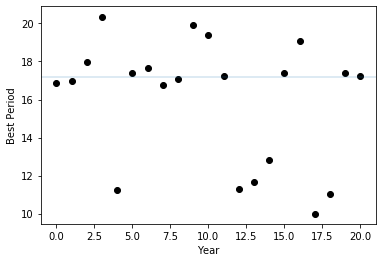

In [49]:
plt.scatter(np.arange(21),bps,color='black')
plt.axhline(orb,alpha=0.2)

plt.ylabel('Best Period')
plt.xlabel('Year')

# 3: Look for Orbital Period with LC

In [40]:
def checkorb(st,end,cen=2131,orb=orb,plcen=False,figsize=(10,4)):
    stday = idays[st:st+1]
    enday = idays[end-1:end]
    fig = plt.figure(figsize=figsize)
    plt.errorbar(idays[st:end],imag[st:end],yerr=ierr[st:end],linestyle='none',marker='o',color=pink,markersize=5)
    maxi,mini = np.max(imag[st:end]),np.min(imag[st:end])
    plt.ylim(maxi+.02,mini-.02)

    fline = int((stday - cen)/orb)
    lline = int((enday - cen)/orb)
    for i in range(fline-1,lline+2):
        plt.axvline(cen+orb*i,alpha=0.2)
    if plcen: plt.axvline(cen,alpha=0.6)
        

In [41]:
def checkpds(st,end,pd1=0.6425,pd2=1.805,det=False,window=7,pbins=10):
    fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
    ttab = iband[st:end]
    if det:
        o.detrend(ttab,window=window)
        mag = ttab['I detrend']
    else: mag = ttab['I mag']
    days = ttab['MJD-50000']
    ax[0].scatter(days%pd1,mag,color=pink,label=str(pd1)+'d',s=6)
    ax[1].scatter(days%pd2,mag,color=pink,label=str(pd2)+'d',s=6)
    ax[0].scatter(pd1+days%pd1,mag,color=pink,s=6)
    ax[1].scatter(pd2+days%pd2,mag,color=pink,s=6)
    maxi,mini = np.max(mag[st:end]),np.min(mag[st:end])
    ax[0].set_ylim(maxi+.01,mini-.01)
    plt.subplots_adjust(wspace=0.05)
    ax[0].legend()
    ax[1].legend()
    
    mid,avg = o.meanphase(ttab,pd1,det=det,pbins=pbins)
    ax[0].plot(mid,avg,color='black',label=str(pd)+'d')
    ax[0].plot(pd1+mid,avg,color='black')

    mid,avg = o.meanphase(ttab,pd2,det=det,pbins=pbins)
    ax[1].plot(mid,avg,color='black',label=str(pd2)+'d')
    ax[1].plot(pd2+mid,avg,color='black')


# 4: Look for Super-Orbital Period with Periodograms

<Quantity 2000.>

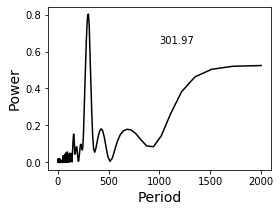

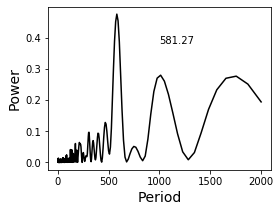

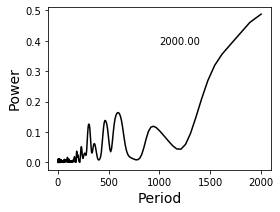

In [42]:
#each OGLE epoch
o.periodogram(ilist[0],maxp=2000)
o.periodogram(ilist[1],maxp=2000)
o.periodogram(ilist[2],maxp=2000)

# 5: Look for Super-Orbital Period with LC